In [37]:
# Import realsense python wrapper
import os
import cv2
import json
import shutil
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pyrealsense2 as rs 
print("Environment Ready")

Environment Ready


## Bag and JSON with coordinates path

In [38]:
RECORDING_PATH = '../dataset/bags/cart_3_red_yellow.bag'
MASK_PATH = '../src/Mask_RCNN/datasets/process'

##  1. Open Recording

In [39]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(RECORDING_PATH)
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
# Frame 300 has 2 peppers with peduncles
for x in range(300):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## Get RGB data

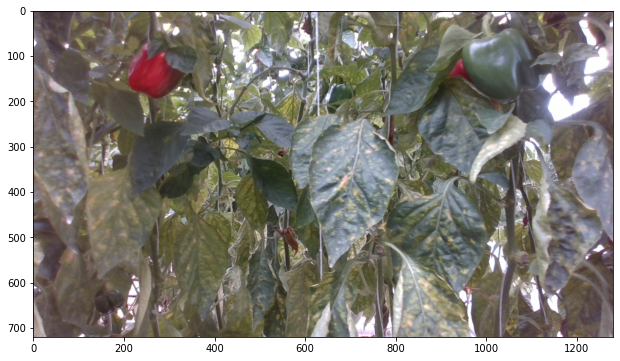

In [40]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

# Get Depth

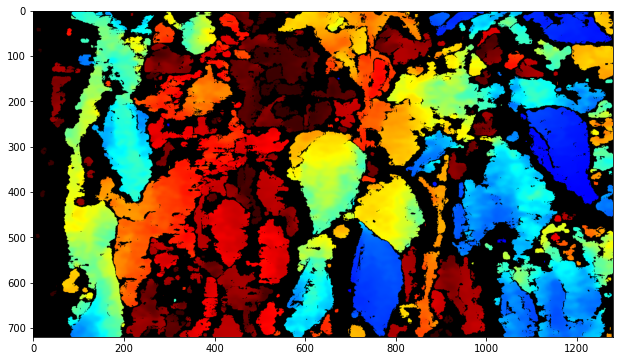

In [41]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Align Depth with color

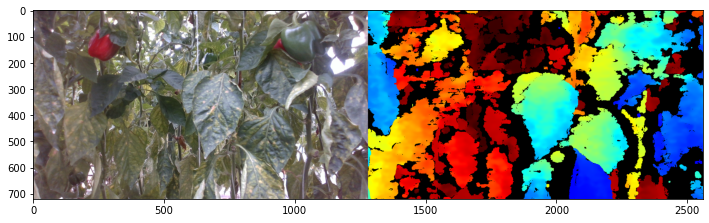

In [42]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

## Save one frame of the recording for inference

In [43]:
im = Image.fromarray(color)
im.save(os.path.join(MASK_PATH + '/frame.png'))
shutil.move(MASK_PATH + '/frame.png', MASK_PATH + '/input/frame.png')

'../src/Mask_RCNN/datasets/process/input/frame.png'

## Reading bounding boxes from json

In [44]:
file_names = next(os.walk(MASK_PATH + '/boxes'))[2]
file_name = file_names[0]
data = []
with open(os.path.join(MASK_PATH + '/boxes/', file_name)) as json_file:
    data = json.load(json_file)
    data = np.array(data, dtype=object)

In [45]:
tmp_img = color.copy()

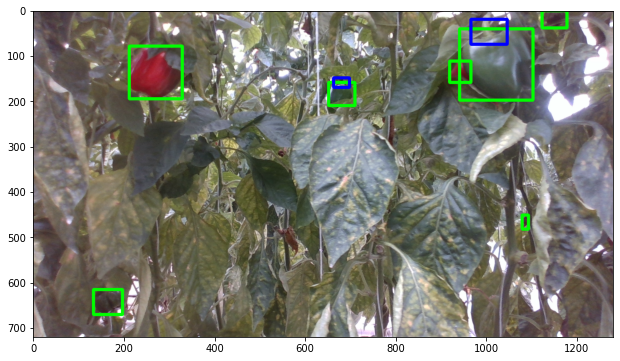

In [46]:
expected = 1 # Scale multiplier, in this case the coordinates are already alligned
xmin = []
ymin = []
xmax = []
ymax = []

for box in data:
    xmin = box[0][1] 
    ymin = box[0][0] 
    xmax = box[0][3] 
    ymax = box[0][2]
    if box[1]== 1:
        cv2.rectangle(tmp_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 255, 0), 5)
    else:
        cv2.rectangle(tmp_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 0, 255), 5)
plt.imshow(tmp_img)

## Get depth data

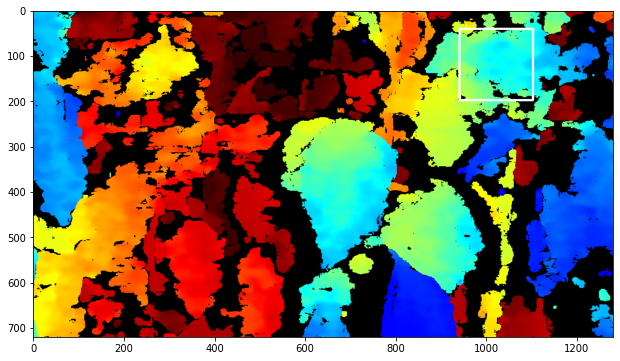

In [47]:
xmin = data[0][0][1]
ymin = data[0][0][0] 
xmax = data[0][0][3] 
ymax = data[0][0][2]

xmin_depth = int((xmin * expected ) )
ymin_depth = int((ymin * expected) )
xmax_depth = int((xmax * expected ) )
ymax_depth = int((ymax * expected) )
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 3)
plt.imshow(colorized_depth)

In [48]:
# Get Depth data from the sensor and crop to the pepper section
depth = np.asanyarray(aligned_depth_frame.get_data())
depth_area = depth[ymin_depth:ymax_depth,  xmin_depth:xmax_depth]
#depth_area.shape

## Get Z (depth from sensor)

In [49]:
# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth_area * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a pepper {} meters away.".format(dist))

Detected a pepper 0.4786489179142833 meters away.


## Get X, Y, and Z from center of detected pepper

In [50]:
# Get the centroid of the bbox
box_center = [
    int((xmax_depth - xmin_depth)/2 + xmin_depth),
    int((ymax_depth - ymin_depth)/2 + ymin_depth)
]
box_center

[1022, 119]

In [51]:
depth_intrin = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
pixel_depth_value,_,_,_ = cv2.mean(depth_area)
coordinates = rs.rs2_deproject_pixel_to_point(depth_intrin, box_center, pixel_depth_value*depth_scale)
print(" X: {} Y: {} Z:{}".format(coordinates[0], coordinates[1], coordinates[2]))

 X: 0.2010759711265564 Y: -0.12954553961753845 Z:0.47864893078804016
